### License
Copyright 2017 Patrick Hall and the H2O.ai team
http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### 0. Project purpose
- This project is to __explain Your Predictive Models to Business Stakeholders__ using LIME with Python and H2O:
    - In this project, an h2o GBM is trained on the __UCI credit card default data__;
    - Predict a highly risky customer  
    - Explain using linear model coefficients and LIME-derived reason codes:
    
        - Describing complex models and generating reason codes with:  
            - Local Interpretable Model-agnostic Explanations (LIME) 
            - LIME-variants

### 1. LIME & Variant of LIME:
- __Local Interpretable Model-agnostic Explanations (LIME)__ shed light on:
    - How almost any machine learning model makes decisions for __specific rows of data__.  

    - LIME builds __local linear surrogate models__ around observations of interest and leverages the highly interpretable properties of linear models to increase transparency and accountability for the corresponding model predictions. 

- __Variant of LIME__:  
    - Easier to execute on new data and that can be analyzed alongside observed (i.e., not simulated) data.

### 2. Code:
#### 2.1: Preparation works-- Python imports & H2O initialize:
In general, NumPy and Pandas will be used for data manipulation purposes and h2o will be used for modeling tasks.

In [90]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # for LIME
from h2o.estimators.gbm import H2OGradientBoostingEstimator # for GBM

import operator # for dictionaries sorting

import numpy as np
import pandas as pd

%matplotlib inline

In [91]:
h2o.init(max_mem_size='2G') #start h2o
h2o.remove_all() # Remove all existing data structures from h2o memory.

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 2 hours 47 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.5
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_Zi_Wei_Fan_a6m35a
H2O cluster total nodes:,1
H2O cluster free memory:,1.638 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


#### 2.2: Data processing: Explore & prepare credit card default data.

- Data source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
- The data set contains 23 input variables:  
    - __LIMIT_BAL__: Amount of given credit (NT dollar)
    - __SEX__: 1 = male; 2 = female
    - __EDUCATION__: 1 = graduate school; 2 = university; 3 = high school; 4 = others
    - __MARRIAGE__: 1 = married; 2 = single; 3 = others
    - __AGE__: Age in years
    - __PAY_0, PAY_2 - PAY_6__: History of past payment; 
        - PAY_0 = the repayment status in September, 2005; 
        - PAY_2 = the repayment status in August, 2005; 
        ...; 
        - PAY_6 = the repayment status in April, 2005. 
    The measurement scale for the repayment status is: 
        - -1 = pay duly; 
        - 1 = payment delay for one month; 
        - 2 = payment delay for two months; ...; 
        - 8 = payment delay for eight months; 
        - 9 = payment delay for nine months and above.
    - __BILL_AMT1 - BILL_AMT6__: Amount of bill statement (NT dollar). 
        - BILL_AMNT1 = amount of bill statement in September, 2005; 
        - BILL_AMT2 = amount of bill statement in August, 2005; ...; 
        - BILL_AMT6 = amount of bill statement in April, 2005.
     - __PAY_AMT1 - PAY_AMT6__: Amount of previous payment (NT dollar). 
         - PAY_AMT1 = amount paid in September, 2005; 
         - PAY_AMT2 = amount paid in August, 2005; ...; 
         - PAY_AMT6 = amount paid in April, 2005.   

### 1. Download, explore, and prepare UCI credit card default data

#### Import data and clean

In [178]:
#  Prediction target (a shorter name): DEFAULT_NEXT_MONTH:
path = 'Dataset/default_of_credit_card_clients.xls'
data = pd.read_excel(path, skiprows=1)

In [179]:
# Remove spaces from target column name:
data = data.rename(columns={'default payment next month':'DEFAULT_NEXT_MONTH'})

In [180]:
data.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


#### Assign modeling roles:

- y: prediction target.
- X: all other input variables in the credit card default data except 'ID'.

In [146]:
y='DEFAULT_NEXT_MONTH'
X=[name for name in data.columns if name not in [y,'ID']]
print('y=', y)
print('X=', X)

y= DEFAULT_NEXT_MONTH
X= ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Parse: Helper function for recoding values:
- This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary, to the original integer values of the input variables found in the dataset.

- These character can be used directly in h2o decision tree models, and the function returns the original Pandas DataFrame as an h2o object, an H2OFrame. （H2o models cannot run on Pandas DataFrames. They require H2OFrames.）

In [147]:
def recode_cc_data(frame):
    """
    Args: 
        frame: Pandas DF of UCI credit card default data.
    Return:
        H2OFrame with recoded values.
    """
    
    #Define recoded values
    sex_dict={1:'male', 2:'female'}
    education_dict={0:'other', 1:'graduate school', 2:'university', 3:'high school', 4:'other', 5:'other', 6:'other'}
    marriage_dict={0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict={-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 2:'2 months delay', 3:'3 months delay', 4:'4 months delay', 5:'5 months delay', 6:'6 months delay', 7:'7 months delay', 8:'8 months delay', 9:'9+ months delay'}
    
    # Recode values by Pandas apply() & anonymous function
    frame['SEX']=frame['SEX'].apply(lambda i:sex_dict[i])
    frame['EDUCATION']=frame['EDUCATION'].apply(lambda i:education_dict[i])
    frame['MARRIAGE']=frame['MARRIAGE'].apply(lambda i:marriage_dict[i])
    
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name]=frame[name].apply(lambda i: pay_dict[i])
    
    return h2o.H2OFrame(frame)


In [148]:
# Recode:
data=recode_cc_data(data) # Now, data is a H2OFrame.

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [149]:
data.head(4)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
1,20000,female,university,married,24,2 months delay,2 months delay,pay duly,pay duly,no consumption,no consumption,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,female,university,single,26,pay duly,2 months delay,use of revolving credit,use of revolving credit,use of revolving credit,2 months delay,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,female,university,single,34,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,female,university,married,37,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


#### Target Processing:  
- Ensure target is handled as a categorical variable

- In h2o, a numeric variable can be treated as numeric or categorical:   The target variable DEFAULT_NEXT_MONTH takes on values of 0 or 1. To ensure this numeric variable is treated as a categorical variable, the __asfactor()__ function is used to explicitly declare that it is a categorical variable. 

In [150]:
data[y]=data[y].asfactor() # changed to a factor by way of the H2OVec operation asfactor.
data.head(4)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
1,20000,female,university,married,24,2 months delay,2 months delay,pay duly,pay duly,no consumption,no consumption,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,female,university,single,26,pay duly,2 months delay,use of revolving credit,use of revolving credit,use of revolving credit,2 months delay,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,female,university,single,34,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,female,university,married,37,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


####  Display descriptive statistics:
- Check a brief description of the credit card default data. For the categorical input variables LIMIT_BAL, SEX, EDUCATION, MARRIAGE, and PAY_0-PAY_6, the new character values created above in cell 5 are visible. Basic descriptive statistics are displayed for numeric inputs.

In [151]:
data.describe()

Rows:30000
Cols:25




,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,1.0,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,15000.5,167484.3226666662,,,,35.485499999999924,,,,,,,51223.330900000044,49179.07516666671,47013.15479999978,43262.94896666666,40311.40096666652,38871.76039999991,5663.5805,5921.163500000007,5225.681500000008,4826.076866666664,4799.3876333333155,5215.502566666671,
maxs,30000.0,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,8660.398374208891,129747.66156720232,,,,9.21790406809017,,,,,,,73635.86057552957,71173.76878252835,69349.38742703672,64332.856133916415,60797.1557702648,59554.107536745825,16563.28035402575,23040.870402057233,17606.961469803107,15666.159744031995,15278.305679144794,17777.465775435343,
zeros,0,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,20000.0,female,university,married,24.0,2 months delay,2 months delay,pay duly,pay duly,no consumption,no consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,female,university,single,26.0,pay duly,2 months delay,use of revolving credit,use of revolving credit,use of revolving credit,2 months delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,female,university,single,34.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


### 2. Train an H2O GBM Classifier:
#### Split into traing data & test data for early stop:
- Splitting could monitor & prevent overtraining.
- Random seed is used to ensure the data split is reproducible.(Because Reproducibility is an important factor in creating trustworthy models, and splitting datasets randomly.)

In [152]:
# Split into training & validation.
train, test=data.split_frame([0.7], seed=12345)

#Summerize split
print('Train data rows=%d, columns=%d' % (train.shape[0], train.shape[1]))
print('Test data rows=%d, columns=%d' % (test.shape[0], test.shape[1]))

Train data rows=21060, columns=25
Test data rows=8940, columns=25


#### Train h2o GBM classifier

- Many tuning parameters must be specified to train a GBM using h2o. 
- Typically a grid search would be performed to __identify the best parameters__ for a given modeling task using the __H2OGridSearch class.__
(For brevity's sake, a previously-discovered set of good tuning parameters are specified here.)
- Because gradient boosting methods typically resample training data, an additional random seed is also specified for the h2o-GBM using seed parameter to create reporducible predictions, error rates and variable important values.
- To avoid overfitting, the  __stopping_rounds__ parameter is used to stop the training process after the test error fails to decrease for 5 iterations.

In [153]:
# Initialize GBM model:
# Could identify the best parameters for a given modeling task using the H2OGridSearch class.
model = H2OGradientBoostingEstimator(ntrees=150,
                                    max_depth=4,
                                    sample_rate=0.9,
                                    col_sample_rate=0.9,
                                    stopping_rounds=5,
                                    score_tree_interval=1,
                                    seed=12345)
model.train(y=y, x=X, training_frame=train, validation_frame=test)
print('GBM test AUC=%.2f' % model.auc(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM test AUC=0.78


### 3. LIME: Generate descriptions for a local region with a perturbed sample.
- A linear model cannot be built on a single observation, so LIME typically requires that a set of rows similar to the row of interest be simulated. 
- Then the records are weighted by their closeness to the record of interest, and a regularized linear model is trained on this weighted explanatory set. The parameters of the linear model and LIME-derived reason codes are then used to explain the prediction for the selected record. Because simulation of new points can seem abstract to some practicioners and simulation and distance calculations can be somewhat burdensome for creating explanations quickly in mission-critical applications.  
- This notebook also presents a variation of LIME in which a more practical sample, instead of a perturbed, simulated sample, is used to __create a local region in which to fit a linear model__.


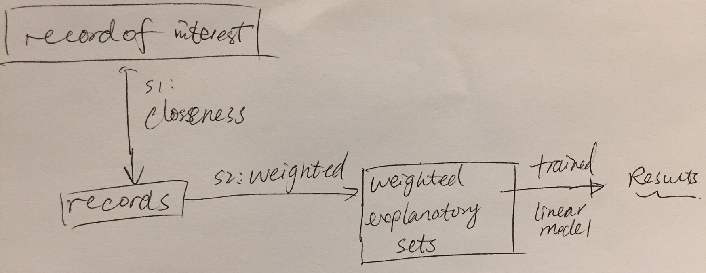

In [154]:
from IPython.display import Image
Image(filename='Image/record.png')

####  Display the most risky customer
-  Row index 29116 was found to contain the riskiest customer in the test dataset according to the h2o GBM model.
-  The riskiest customer is selected first for analysis as an exercise in __boundary testing__.

In [155]:
row=test[test['ID']==29116]
row

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
29116,20000,female,university,married,59,3 months delay,2 months delay,3 months delay,2 months delay,2 months delay,4 months delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,1


- To use LIME, a sample of similar (i.e., near or local) points is simulated around the customer of interest.   
- This simple function draws numeric values from normal distributions centered around the customer of interest and draws categorical values at random from the variable values in the test set.

In [156]:
def generate_local_sample(row, frame, X, N=1000):
    """Generate a perturbed sample around a row of interest.
    
    Args:
        row: Row of H2OFrame to be explained.
        frame: H2OFrame in which row is stored.
        X: List of model input variables.
        N: Number of samples to generate.
        
     Return:
         Pandas DataFrame containing perturbed samples.
    """
    
    # Initialize pandas dataframe:
    sample_frame=pd.DataFrame(data=np.zeros(shape=(N, len(X))), columns=X)
    
    # Generate column vectors of randomly drawn levels for categorial variables
    # normally distributed numeric values around mean of column for numeric variables
    for key, val in frame[X].types.items():
        if val == 'enum':
            rs = np.random.RandomState(11111) # If enum: random sed for reproducibility
            draw = rs.choice(frame[key].levels()[0], size=(1,N))[0] # rs.choice(): returns a random item from a list, tuple, or string.
        else:
            rs=np.random.RandomState(11111)
            loc=row[key][0,0]
            sd=frame[key].sd()
            draw=rs.normal(loc,sd,(N,1))
            draw[draw<0]=loc # prevents unrealistic values when std. dev. is large
        
        sample_frame[key]=draw
    
    return sample_frame

In [157]:
perturbed_sample=generate_local_sample(row, test, X)
perturbed_sample.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,9988.454213,female,graduate school,divorced,58.287510,5 months delay,5 months delay,5 months delay,5 months delay,6 months delay,...,5433.340804,6276.576876,8055.530587,7347.467911,1597.834490,0.000000,1000.000000,823.253257,0.000000,0.000000
1,181039.642122,male,high school,married,70.460689,pay duly,pay duly,pay duly,pay duly,use of revolving credit,...,94937.888614,90412.278099,87766.906051,85915.192926,22137.303918,25583.930273,21802.010398,20928.433066,19123.775929,22563.515833
2,20000.000000,male,university,single,43.284233,7 months delay,7 months delay,7 months delay,7 months delay,8 months delay,...,10672.000000,11201.000000,12721.000000,11946.000000,2800.000000,0.000000,1000.000000,2000.000000,0.000000,0.000000


#### Calculate distance between row of interest and perturbed sample
-  Before fitting a penalized regression model, and the sample is simulated, then distances from the point of interest are used to weigh each point.
- Pandas has convenient functionality for one-hot encoding, and the H2OFrames are temporarily casted back to Pandas DataFrames to perform the encoding.(Since Euclidean distance calculations require numeric quanitites, categorical input variables are one-hot encoded.)
- Numeric input variables are standardized, from  skewing Euclidean distances, to prevent the disparate scales of numeric values, such as AGE and LIMIT_BAL.

First, the row containing the riskiest customer is encoded and standardized.

In [158]:
# Scaling & one-hot encoding for calculating Euclidian distance
# for the row of interest

# Scale numeric
numeric = list(set(X)-set(['ID','SEX','EDUCATION', 'MARRIAGE','PAY_0','PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH']))
scaled_test = test.as_data_frame() 
# as_data_frame(): Obtain the dataset as a python-local object (pandas frame if possible, list otherwise)
# Returns:	A local python object containing this H2OFrame instance’s data.

scaled_test[numeric] = (scaled_test[numeric]-scaled_test[numeric].mean())/scaled_test[numeric].std()

#encode categorical
row_df = scaled_test[scaled_test['ID']==22760]
row_dummies = pd.concat([row_df.drop(['ID','SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2',
                                      'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH'], axis=1),
                         pd.get_dummies(row_df[['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])],
                        axis=1) # get_dummies(): Convert categorical variable into dummy/indicator variables
# Convert to H2OFrame
row_dummies = h2o.H2OFrame(row_dummies)
row_dummies

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 months delay,PAY_2_2 months delay,PAY_3_2 months delay,PAY_4_3 months delay,PAY_5_3 months delay,PAY_6_3 months delay
2.24639,0.481433,-0.66112,-0.657958,-0.651883,-0.637776,-0.622867,-0.609179,-0.360791,-0.282325,-0.315203,-0.319038,-0.319074,-0.270536,1,1,1,1,1,1,1,1,1


 Then the simulated sample is encoded and standardized.

In [159]:
# scaling and one-hot encoding for calculating Euclidian distance 
# for the simulated sample

# scale
scaled_perturbed_sample = perturbed_sample[numeric].copy(deep=True)# -When deep=True, data is copied but actual Python objects will not be copied recursively, only the reference to the object.
scaled_perturbed_sample = (scaled_perturbed_sample-scaled_perturbed_sample.mean())/scaled_perturbed_sample.std()

# encode
perturbed_sample_dummies = pd.concat([scaled_perturbed_sample, pd.get_dummies(perturbed_sample[['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2',
                                      'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])], axis=1)

# Convert to H2OFrame
perturbed_sample_dummies = h2o.H2OFrame(perturbed_sample_dummies[row_dummies.columns])

# Print
perturbed_sample_dummies.head(3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 months delay,PAY_2_2 months delay,PAY_3_2 months delay,PAY_4_3 months delay,PAY_5_3 months delay,PAY_6_3 months delay
-0.845634,-0.0955699,-0.84979,-0.845174,-0.845174,-0.83886,-0.834367,-0.834967,-0.83834,-0.723503,-0.722209,-0.849042,-0.723503,-0.723503,1,1,0,0,0,0,0,0,0
1.41903,1.2011,1.41949,1.41897,1.41897,1.4182,1.4176,1.41769,1.41814,1.41999,1.41993,1.41941,1.41999,1.41999,0,0,1,0,0,0,0,0,0
-0.713084,-1.69369,-0.716971,-0.712654,-0.712654,-0.706755,-0.70256,-0.70312,-0.706269,-0.723503,-0.722209,-0.716271,-0.723503,-0.723503,0,0,0,0,0,0,0,0,0


- Variables are often scaled (i.e. standardized) before measuring the inter-observation dissimilarities. Generally variables are scaled to have standard deviation one and mean zero. 

- Distance is calculated using h2o:
max distance - distance --> Change the distance values into similairity values.
Now the observation with the highest values are those that are closest to the observation of interest.
And they will carry the most weight in the local explanatory linear model.  
 

- Similarity values samples:

In [160]:
distance = row_dummies.distance(perturbed_sample_dummies, measure='l2').transpose()
distance.columns = ['distance'] # Rename
distance = distance.max()-distance
distance.head(3)

#A generalized term for the Euclidean norm is the L2 norm or L2 distance.

distance
13.2143
10.2477
12.6506


#### Bind distance weights onto perturbed sample
- To fit an h2o linear model using the similarities as observation weights, the distance column must reside in the same H2OFrame as the simulated sample data.

In [161]:
perturbed_sample = h2o.H2OFrame(perturbed_sample).cbind(distance)
# h2o-cbin(): Takes a sequence of H2O data sets and combines them by colum
perturbed_sample.head(3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance
9988.45,female,graduate school,divorced,58.2875,5 months delay,5 months delay,5 months delay,5 months delay,6 months delay,6 months delay,3152.62,5678.04,5433.34,6276.58,8055.53,7347.47,1597.83,0,1000,823.253,0,0,13.2143
181040,male,high school,married,70.4607,pay duly,pay duly,pay duly,pay duly,use of revolving credit,use of revolving credit,99691.6,98946.5,94937.9,90412.3,87766.9,85915.2,22137.3,25583.9,21802,20928.4,19123.8,22563.5,10.2477
20000,male,university,single,43.2842,7 months delay,7 months delay,7 months delay,7 months delay,8 months delay,8 months delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,12.6506


#### Bind model predictions onto perturbed sample
- For LIME, the target of the explanatory local linear model: the predictions of the GBM model in the local simulated sample. 
- The values are calculated and column-bound to the simulated sample.

In [162]:
preds1 = model.predict(perturbed_sample)
preds1.head(3)
#p0 is the probability (between 0 and 1) that class 0 is chosen.
#p1 is the probability (between 0 and 1) that class 1 is chosen.'''

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.484803,0.515197
0,0.933602,0.0663977
1,0.307319,0.692681


In [163]:
preds1=preds1.drop(['predict','p0'])
preds1.head(3)

p1
0.515197
0.0663977
0.692681


In [164]:
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1.columns = [yhat] # Rename 'p1' of preds to 'p_DEFAULT_NEXT_MONTH'
perturbed_sample = perturbed_sample.cbind(preds1)
perturbed_sample.head(3)

LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance,p_DEFAULT_NEXT_MONTH
9988.45,female,graduate school,divorced,58.2875,5 months delay,5 months delay,5 months delay,5 months delay,6 months delay,6 months delay,3152.62,5678.04,5433.34,6276.58,8055.53,7347.47,1597.83,0,1000,823.253,0,0,13.2143,0.515197
181040,male,high school,married,70.4607,pay duly,pay duly,pay duly,pay duly,use of revolving credit,use of revolving credit,99691.6,98946.5,94937.9,90412.3,87766.9,85915.2,22137.3,25583.9,21802,20928.4,19123.8,22563.5,10.2477,0.0663977
20000,male,university,single,43.2842,7 months delay,7 months delay,7 months delay,7 months delay,8 months delay,8 months delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,12.6506,0.692681


#### Train penalized linear model in local region
- After  simulated sample has been weighted with distances and contains the GBM model predictions,  
A linear model is fit to the original inputs and the GBM model predictions, weighted by similarity to the row of interest. weighted by similarity to the row of interest.  
- The trained GLM coefficients are helpful for understanding the local region of response function around the riskiest customer.

In [165]:
# Initialize
local_glm1 = H2OGeneralizedLinearEstimator(lambda_search=True, 
                                           weights_column='distance', 
                                           seed=12345)

#Train
local_glm1.train(x=X, y=yhat, training_frame=perturbed_sample)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [166]:
print(local_glm1.coef().items())

dict_items([('Intercept', 0.4266979267521642), ('PAY_0.1 month delay', 0.0), ('PAY_0.2 months delay', 0.0), ('PAY_0.3 months delay', 0.0), ('PAY_0.4 months delay', 0.0), ('PAY_0.5 months delay', 0.0), ('PAY_0.6 months delay', 0.0), ('PAY_0.7 months delay', 0.0), ('PAY_0.8 months delay', 0.0), ('PAY_0.no consumption', 0.0), ('PAY_0.pay duly', 0.0), ('PAY_0.use of revolving credit', 0.0), ('PAY_2.1 month delay', 0.0), ('PAY_2.2 months delay', 0.0), ('PAY_2.3 months delay', 0.0), ('PAY_2.4 months delay', 0.0), ('PAY_2.5 months delay', 0.0), ('PAY_2.6 months delay', 0.0), ('PAY_2.7 months delay', 0.0), ('PAY_2.8 months delay', 0.0), ('PAY_2.no consumption', 0.0), ('PAY_2.pay duly', 0.0), ('PAY_2.use of revolving credit', 0.0), ('PAY_3.1 month delay', 0.0), ('PAY_3.2 months delay', 0.0), ('PAY_3.3 months delay', 0.0), ('PAY_3.4 months delay', 0.0), ('PAY_3.5 months delay', 0.0), ('PAY_3.6 months delay', 0.0), ('PAY_3.7 months delay', 0.0), ('PAY_3.8 months delay', 0.0), ('PAY_3.no consumpti

In [167]:
# Coefs:
# ljust(): returns the string left justified in a string of length width.
# itemgetter(): Return a callable object that fetches item from its operand using the operand’s __getitem__() method.
# e.g.: temgetter(1,3,5)('ABCDEFG')--> output: ('B', 'D', 'F')
print('\nLocal Positive GML Coefficients:')
for c_name, c_val in sorted(local_glm1.coef().items(), key=operator.itemgetter(1)):
    if c_val>0.0:
        print("%s %s" %(str(c_name+':').ljust(25), c_val))


Local Positive GML Coefficients:
Intercept:                0.4266979267521642


In [168]:
# r2: R-squared measures how much variation in your data can be explained by the linear regression.
print('\nLocal GLM R-Square:\n%.2f' % local_glm1.r2())


Local GLM R-Square:
0.05


- The coefficients of the local linear model describe the __average behavior of the GBM response function around the riskiest customer__. 
- In this local region, customers who missed payments, particularly PAY_0, PAY_5, and PAY_6, are treated as the most likely to default.

### 4. Generate __reason codes__ with LIME based on a perturbed sample
- Plot reason code values in a bar chart by:
    - coefficients of the local linear explanatory model
    - values in the row of interest  
- __Estimates of how much each variable contributed to each prediction decision = local GLM coefficient * the value in a specific row__
- Crucially important for machine learning interpretability:  These values can tell you how a variable and its values were weighted in any given decision by the model- often to referred to "local feature importance", "reason codes".
- Reason codes can be easily extracted from LIME local feature importance values by simply ranking the variables that played the largest role in any given decision.

In [169]:
 def plot_local_contrib(row, model, X): 

    """ Plots reason codes in a bar chart. 
    
    Args:
    
        row: Row of H2OFrame to be explained.
        model: H2O linear model used for generating reason codes.
        X: List of model input variables.
    
    """
    
    # initialize Pandas DataFrame to store results
    local_contrib_frame = pd.DataFrame(columns=['Name', 'Local Contribution', 'Sign'])
    
    # multiply values in row by local glm coefficients    
    for key, val in sorted(row[X].types.items()):
        contrib = 0
        name = ''
        if val == 'enum':
                level = row[key][0, 0]
                name = '.'.join([str(key), str(level)])
                if name in model.coef():
                    contrib = model.coef()[name]
        else:
            name = key
            if name in model.coef():
                contrib = row[name][0, 0]*model.coef()[name]
        
        # save only non-zero values
        if contrib != 0.0:
            local_contrib_frame = local_contrib_frame.append({'Name': name,
                                                              'Local Contribution': contrib,
                                                              'Sign': contrib > 0}, 
                                                             ignore_index=True) 
    
    # plot
    _ = local_contrib_frame.plot(x='Name',
                                 y='Local Contribution',
                                 kind='bar', 
                                 title='Reason Codes', 
                                 color=''.join(local_contrib_frame.Sign.map({True:'b', False:'g'}).values), 
                                 legend=False) 

#### Display the reason codes:
- Here it can be seen that the riskiest customer's prediction is driven by her values for payment variables. 
- the top five LIME-derived reason codes contributing to her high probability of default are:
        - Most recent payment is 3 months delayed.
        - 2nd most recent payment is 2 months delayed.
        - 3rd most recent payment is 3 months delayed.
        - Customer Age is 59.
        - 4th most recent payment is 2 months delayed.
    (Of course, in many places, variables like MARRIAGE, AGE, and SEX cannot be used in credit lending decisions.)
- The LIME reason codes and linear model coefficients tell a __relatively parsimonious story about the GBM's prediction behavior__. If this was not so, steps should be taken to either reconcile or remove inconsistencies and unreasonable predictions.



- LIME explanations are linear, do not consider interactions, and represent offsets from the local linear model intercept. 

- LOCO importance values are nonlinear, do consider interactions, and do not explicitly consider a linear intercept or offset.

- It is recommended that users employ several different explanatory techniques and trust only consistent results across techniques.

In [170]:
plot_local_contrib(row, local_glm1, X)

TypeError: Empty 'DataFrame': no numeric data to plot

### 5. Use LIME to generate descriptions for a local region with a practical sample.
- If the sample is too large, the explanatory linear model maybe not be accurate enough to explain all predictions in the sample.

#### Create a local region based on SEX and merge with GBM model predictions

- Instead of using a perturbed simulated sample, Linear model will be fit on all women in the test set, and the sample is not weighted by distance from any one point.

- A few lines of all female sample are displayed directly below.

In [171]:
preds2 = model.predict(test).drop(['predict','p0'])
preds2.columns=[yhat]
practical_sample=test.cbind(preds2)
practical_sample=practical_sample[practical_sample['SEX']=='female']
practical_sample.head(3)

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
4,50000,female,university,married,37,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.144991
8,100000,female,university,single,23,use of revolving credit,pay duly,pay duly,use of revolving credit,use of revolving credit,pay duly,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,0.128193
16,50000,female,high school,divorced,23,1 month delay,2 months delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,50614,29173,28116,28771,29531,30211,0,1500,1100,1200,1300,1100,0,0.325205


#### Train penalized linear model in local region
- A penalized model is trained in the local region defined by women in the test set.
- Because fit is a concern in this much larget explanatory sample, user should __always check the R2__ or other goodness-of-fit measures to ensure surrogate model is accurate.

In [172]:
# Initialize
local_glm2=H2OGeneralizedLinearEstimator(lambda_search=True, seed=12345)

#Train
local_glm2.train(x=X, y=yhat, training_frame=practical_sample)

#coefs
print('\nLocal Positive GLM Coefficients:')
for c_name, c_val in sorted(local_glm2.coef().items(), key=operator.itemgetter(1)):
    if c_val>0.0:
        print('%s %s' % (str(c_name+':').ljust(25), c_val))
        
# R2:
print('\nLocal GLM R-2:\n%.2f' % local_glm2.r2())
        

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local Positive GLM Coefficients:
BILL_AMT5:                1.1826997991308345e-07
BILL_AMT2:                1.40866409117354e-07
PAY_2.use of revolving credit: 8.019899530507052e-05
PAY_5.no consumption:     0.0005253910928260071
AGE:                      0.0005358697742774277
EDUCATION.high school:    0.001738945706593454
PAY_6.5 months delay:     0.003746060705692238
EDUCATION.university:     0.0050869233726203505
MARRIAGE.divorced:        0.008137713429375004
PAY_3.2 months delay:     0.009655714764721601
PAY_6.7 months delay:     0.009949478307751001
MARRIAGE.married:         0.010783461117748264
PAY_6.2 months delay:     0.017777285984771147
PAY_4.4 months delay:     0.018246956356881238
PAY_0.5 months delay:     0.02282693801079417
PAY_5.3 months delay:     0.02513913532234654
PAY_2.2 months delay:     0.027053294000875572
PAY_2.3 months delay:     0.027735314903293225
PAY_3.3 months delay:     0.03

+ The R2 is quite high for this local sample and linear model.  
+ Bcz the sample is simply the women test set and model fit is acceptable, the linear model and coefficients can be used to understand the average behavior of women in the test set.
+ Commonly, late payments(like PAY_0, PAY_2, PAY_6) are the most likely to push GBM to higher probability of default values for women.

### 6. Generate a ranked predictions plot to assess validity of local explanatory model.

- A ranked prediction plots:
    - Can also be used to ensure the local linear surrogate model is a good fit for the model inputs and predictions.
    - A way to __visually check__ whether the surrogate model is good fit for the complex model.
    - Axises:
        - X: the rank of a point when the predictions are sorted by their GBM prediction, from lowest to highest;
        - Y: numeric prediction of both models for a given point. 
    - When both sets of predictions are aligned, as they are below, this is a good surrogate model fits the complex, nonlinear GBM well.
    

In [190]:
pred_frame = local_glm2.predict(practical_sample)
pred_frame.head(3)

glm prediction progress: |████████████████████████████████████████████████| 100%


predict
0.145582
0.0734482
0.316162


In [191]:
pred_frame = pred_frame.cbind(practical_sample)
pred_frame.head(3)

predict,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
0.145582,4,50000,female,university,married,37,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.144991
0.0734482,8,100000,female,university,single,23,use of revolving credit,pay duly,pay duly,use of revolving credit,use of revolving credit,pay duly,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,0.128193
0.316162,16,50000,female,high school,divorced,23,1 month delay,2 months delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,50614,29173,28116,28771,29531,30211,0,1500,1100,1200,1300,1100,0,0.325205


In [192]:
pred_frame=pred_frame.as_data_frame()[['predict', yhat]]
pred_frame.head(3)

,predict,p_DEFAULT_NEXT_MONTH
0,0.145582,0.144991
1,0.073448,0.128193
2,0.316162,0.325205


In [189]:
pred_frame.columns=['Surrogate Preds.', 'ML Preds.']
pred_frame.head(3)

,Surrogate Preds.,ML Preds.
0,0.145582,0.144991
1,0.073448,0.128193
2,0.316162,0.325205


In [174]:
pred_frame.sort_values(by='ML Preds.', inplace=True)
pred_frame.reset_index(inplace=True, drop=True)
#pred_frame.head(3)

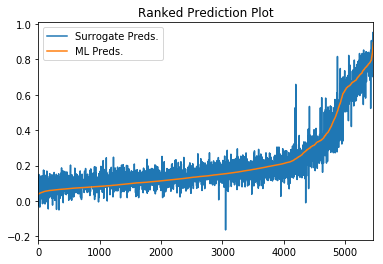

In [175]:
_=pred_frame.plot(title='Ranked Prediction Plot')

   Both the R<sup>2</sup> and ranked predictions plot show the linear model is a good fit in the practical, approximately local sample.   
    This means the regression coefficients are likely a very accurate representation of the behavior of the nonlinear model in this region.

### 7. Generate reason codes using a practical sample
####  Create explanations ('reason codes') for a row in the local set:
    Women's PAY_0 is the most important local contributor to her GBM prediction.
    - PAY_0 followed by other payment variables, marital status etc  play a role in the model decision.

ValueError: Invalid RGBA argument: 'bgbggbgbgbbbbbbgggg'

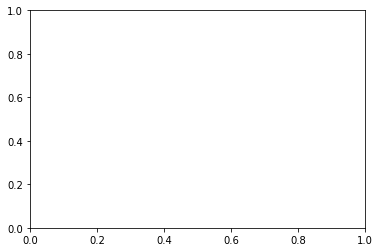

In [176]:
plot_local_contrib(row, local_glm2, X)

- row=test[test['ID']==29116]

####  Shutdown H2O
- be careful, this can erase your work!

In [ ]:
#h2o.cluster().shutdown(prompt=True)

### Summary
- In this notebook, LIME was used to explain and generate reason codes for a complex GBM classifier.  
- To do so, local linear models were fit to appropriate, representative samples and linear model coefficients were used to explain the average behavior in the samples and to create reason codes. Reason codes were assesed against domain knowledge and reasonable expectations. 
- A ranked prediction plot was also introduced to compare surrogate linear model predictions to GBM model predictions. 
- These techniques should generalize well for many types of business and research problems, enabling you to train a complex machine learning model and analyze, validate, and explain it to your colleagues, bosses, and potentially, external regulators.

### Architecture:

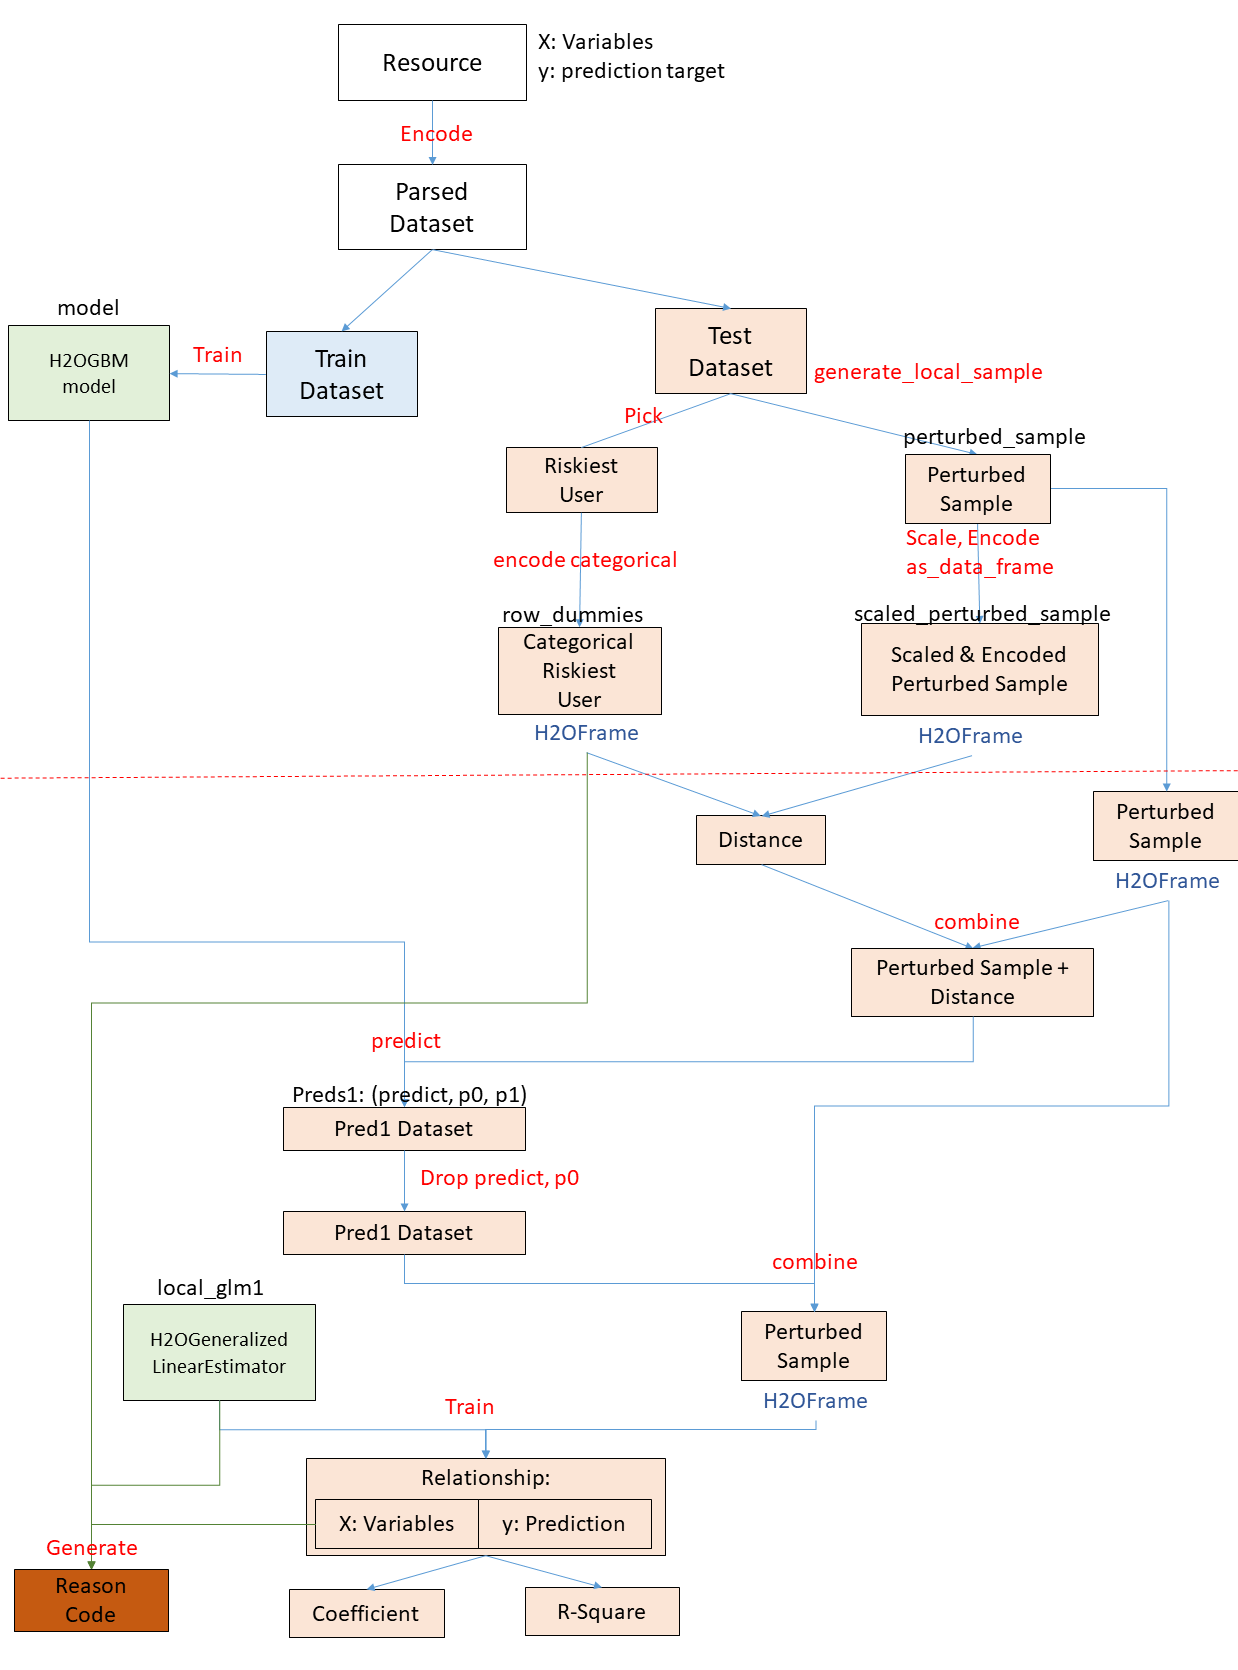

In [193]:
from IPython.display import Image
Image(filename='Image/CreditCard_LIME_Archi-2.png')

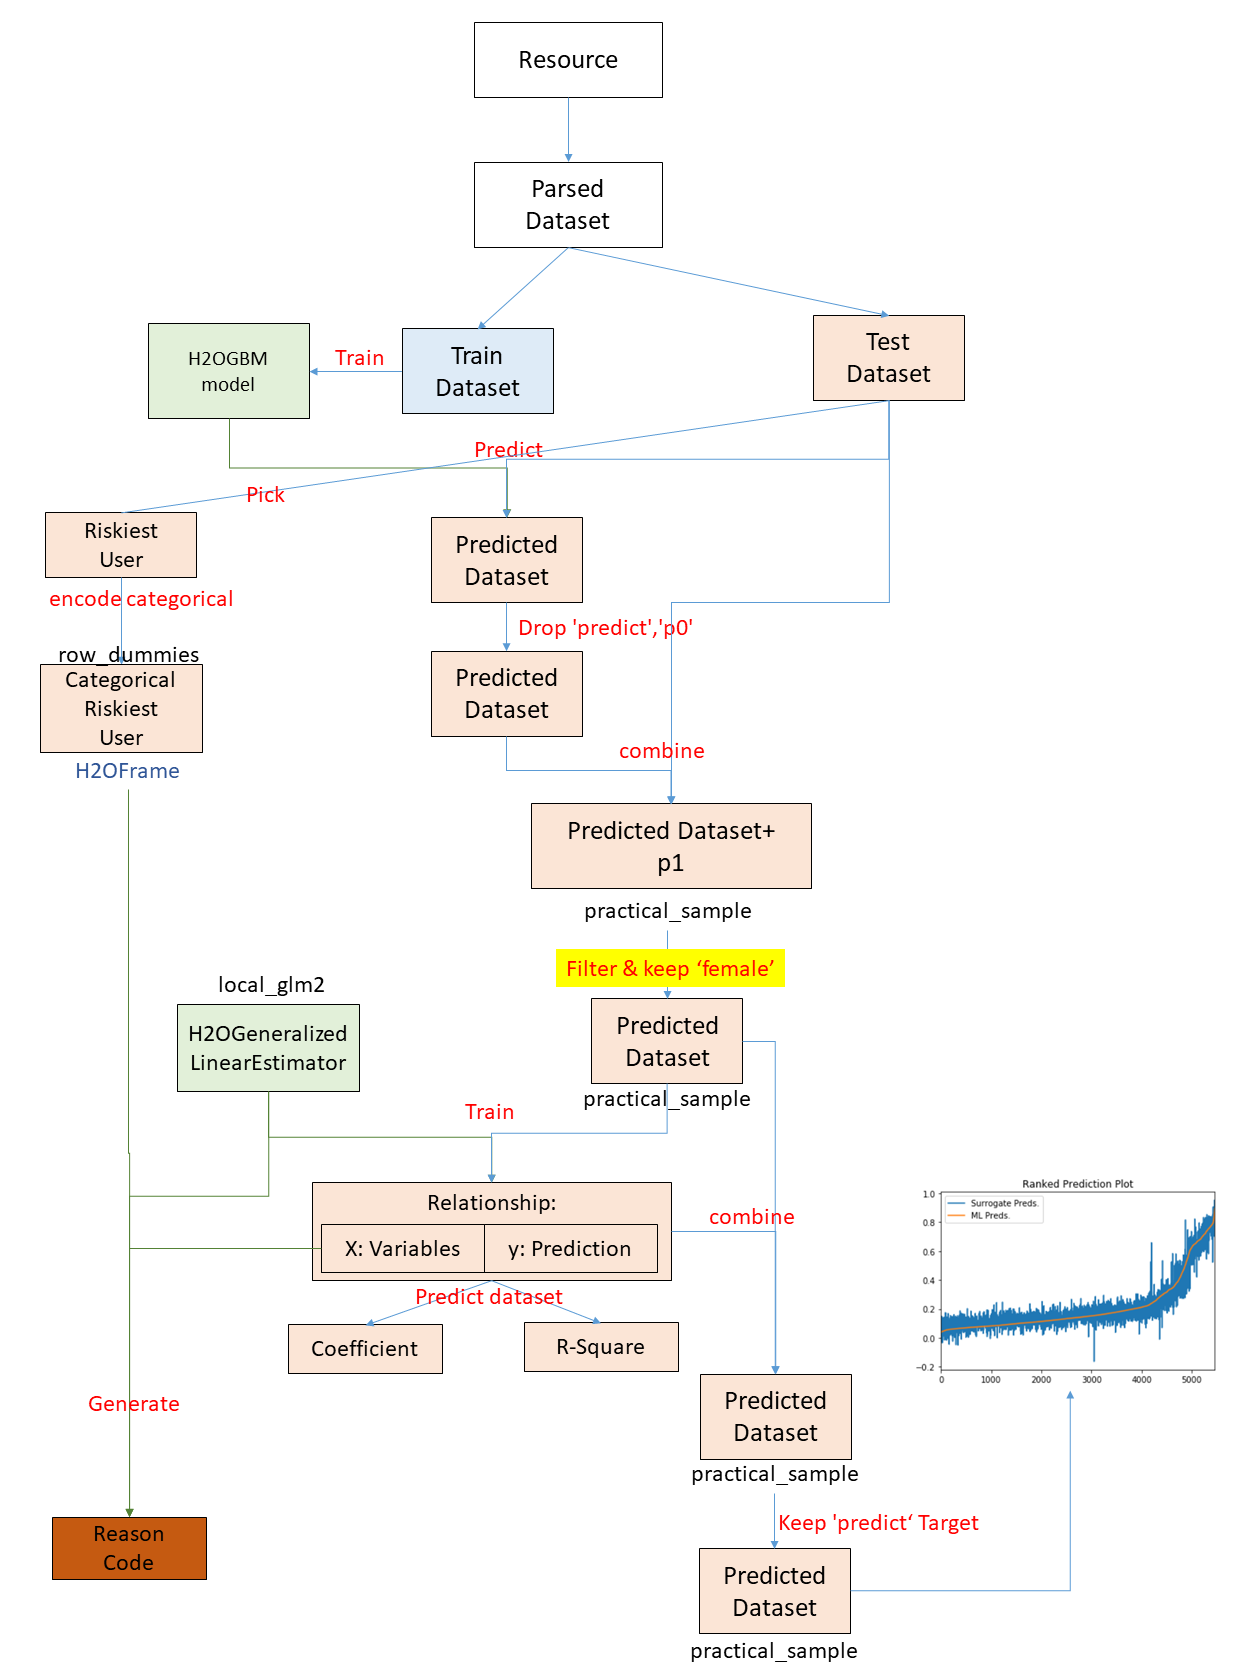

In [194]:
from IPython.display import Image
Image(filename='Image/CreditCard_LIME_Archi-1.png')